In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import xgboost as xgb
import datetime
import operator
from sklearn.cross_validation import train_test_split
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from pylab import plot, show, subplot, specgram, imshow, savefig
from sklearn.metrics import log_loss, make_scorer, accuracy_score
from sklearn.preprocessing import MinMaxScaler

RS = 12357
ROUNDS = 315

print("Started")
np.random.seed(RS)
input_folder = '../kaggle-quora/data/'

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Started


In [2]:
def train_xgb(X, y, params):
    print("Will train XGB for {} rounds, RandomSeed: {}".format(ROUNDS, RS))
    x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RS)

    xg_train = xgb.DMatrix(x, label=y_train)
    xg_val = xgb.DMatrix(X_val, label=y_val)

    watchlist  = [(xg_train,'train'), (xg_val,'eval')]
    return xgb.train(params, xg_train, ROUNDS, watchlist)

def predict_xgb(clr, X_test):
    return clr.predict(xgb.DMatrix(X_test))

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

def add_word_count(x, df, word):
    x['q1_' + word] = df['question1'].apply(lambda x: (word in str(x).lower())*1)
    x['q2_' + word] = df['question2'].apply(lambda x: (word in str(x).lower())*1)
    x[word + '_both'] = x['q1_' + word] * x['q2_' + word]

In [3]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller

def get_weight(count, eps=10000, min_count=2):
    return 0 if count < min_count else 1 / (count + eps)

def word_shares(row):
    q1_list = str(row['question1']).lower().split()
    q1 = set(q1_list)
    q1words = q1.difference(stops)
    if len(q1words) == 0:
        return '0:0:0:0:0:0:0:0'

    q2_list = str(row['question2']).lower().split()
    q2 = set(q2_list)
    q2words = q2.difference(stops)
    if len(q2words) == 0:
        return '0:0:0:0:0:0:0:0'

    words_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1])/max(len(q1_list), len(q2_list))

    q1stops = q1.intersection(stops)
    q2stops = q2.intersection(stops)

    q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
    q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])

    shared_2gram = q1_2gram.intersection(q2_2gram)

    shared_words = q1words.intersection(q2words)
    shared_weights = [weights.get(w, 0) for w in shared_words]
    q1_weights = [weights.get(w, 0) for w in q1words]
    q2_weights = [weights.get(w, 0) for w in q2words]
    total_weights = q1_weights + q1_weights

    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = len(shared_words) / (len(q1words) + len(q2words) - len(shared_words)) #count share
    R31 = len(q1stops) / len(q1words) #stops in q1
    R32 = len(q2stops) / len(q2words) #stops in q2
    Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
    Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
    if len(q1_2gram) + len(q2_2gram) == 0:
        R2gram = 0
    else:
        R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
    return '{}:{}:{}:{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32, R2gram, Rcosine, words_hamming)

In [4]:
%%time

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.11
params['max_depth'] = 5
params['silent'] = 1
params['seed'] = RS

df_train = pd.read_csv(input_folder + 'train.csv')
df_test  = pd.read_csv(input_folder + 'test.csv')

print("Original data: X_train: {}, X_test: {}".format(df_train.shape, df_test.shape))
print("Features processing, be patient...")


train_qs = pd.Series(df_train['question1'].tolist() + \
                     df_train['question2'].tolist()).astype(str)
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

stops = set(stopwords.words("english"))


df = pd.concat([df_train, df_test])
df['word_shares'] = df.apply(word_shares, axis=1, raw=True)

Original data: X_train: (404290, 6), X_test: (2345796, 3)
Features processing, be patient...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 4min 50s, sys: 5.97 s, total: 4min 56s
Wall time: 4min 58s


In [5]:
%%time

x = pd.DataFrame()

x['word_match']       = df['word_shares'].apply(lambda x: float(x.split(':')[0]))
x['word_match_2root'] = np.sqrt(x['word_match'])
x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
x['shared_count']     = df['word_shares'].apply(lambda x: float(x.split(':')[2]))

x['stops1_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[3]))
x['stops2_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[4]))
x['shared_2gram']     = df['word_shares'].apply(lambda x: float(x.split(':')[5]))
x['cosine']           = df['word_shares'].apply(lambda x: float(x.split(':')[6]))
x['words_hamming']    = df['word_shares'].apply(lambda x: float(x.split(':')[7]))
x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']

x['len_q1'] = df['question1'].apply(lambda x: len(str(x)))
x['len_q2'] = df['question2'].apply(lambda x: len(str(x)))
x['diff_len'] = x['len_q1'] - x['len_q2']

x['caps_count_q1'] = df['question1'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['caps_count_q2'] = df['question2'].apply(lambda x:sum(1 for i in str(x) if i.isupper()))
x['diff_caps'] = x['caps_count_q1'] - x['caps_count_q2']

x['len_char_q1'] = df['question1'].apply(lambda x: len(str(x).replace(' ', '')))
x['len_char_q2'] = df['question2'].apply(lambda x: len(str(x).replace(' ', '')))
x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

x['len_word_q1'] = df['question1'].apply(lambda x: len(str(x).split()))
x['len_word_q2'] = df['question2'].apply(lambda x: len(str(x).split()))
x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']

x['exactly_same'] = (df['question1'] == df['question2']).astype(int)
x['duplicated'] = df.duplicated(['question1','question2']).astype(int)

CPU times: user 1min 19s, sys: 1.58 s, total: 1min 21s
Wall time: 1min 21s


# Add Magic Features.

In [6]:
%%time

train_combine = pd.read_csv('../kaggle-quora/features/train_magic.csv', header=0)
test_combine = pd.read_csv('../kaggle-quora/features/test_magic.csv', header=0)
df_combine = pd.concat([train_combine, test_combine])
x['q1_freq'] = df_combine['q1_freq']
x['q2_freq'] = df_combine['q2_freq']

CPU times: user 992 ms, sys: 208 ms, total: 1.2 s
Wall time: 1.21 s


# Other Features

In [7]:
%%time

add_word_count(x, df,'how')
add_word_count(x, df,'what')
add_word_count(x, df,'which')
add_word_count(x, df,'who')
add_word_count(x, df,'where')
add_word_count(x, df,'when')
add_word_count(x, df,'why')

print(x.columns)
print(x.describe())

Index(['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count',
       'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine',
       'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len',
       'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1',
       'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2',
       'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word',
       'exactly_same', 'duplicated', 'q1_freq', 'q2_freq', 'q1_how', 'q2_how',
       'how_both', 'q1_what', 'q2_what', 'what_both', 'q1_which', 'q2_which',
       'which_both', 'q1_who', 'q2_who', 'who_both', 'q1_where', 'q2_where',
       'where_both', 'q1_when', 'q2_when', 'when_both', 'q1_why', 'q2_why',
       'why_both'],
      dtype='object')
         word_match  word_match_2root  tfidf_word_match  shared_count  \
count  2.744371e+06      2.744371e+06      2.750086e+06  2.750086e+06   
mean   1.542752e-01      3.228801e-01      2.016003e-01  1.605620e+00   


# Oversampling and Train/Test Split

In [8]:
%%time

feature_names = list(x.columns.values)
create_feature_map(feature_names)
print("Features: {}".format(feature_names))

x_train = x[:df_train.shape[0]]
x_test  = x[df_train.shape[0]:]
y_train = df_train['is_duplicate'].values
del x, df_train

if 0: # Now we oversample the negative class - on your own risk of overfitting!
    pos_train = x_train[y_train == 1]
    neg_train = x_train[y_train == 0]

    print("Oversampling started for proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
    print("Oversampling done, new proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))

    x_train = pd.concat([pos_train, neg_train])
    y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
    del pos_train, neg_train

Features: ['word_match', 'word_match_2root', 'tfidf_word_match', 'shared_count', 'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'cosine', 'words_hamming', 'diff_stops_r', 'len_q1', 'len_q2', 'diff_len', 'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1', 'len_char_q2', 'diff_len_char', 'len_word_q1', 'len_word_q2', 'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word', 'exactly_same', 'duplicated', 'q1_freq', 'q2_freq', 'q1_how', 'q2_how', 'how_both', 'q1_what', 'q2_what', 'what_both', 'q1_which', 'q2_which', 'which_both', 'q1_who', 'q2_who', 'who_both', 'q1_where', 'q2_where', 'where_both', 'q1_when', 'q2_when', 'when_both', 'q1_why', 'q2_why', 'why_both']
Oversampling started for proportion: 0.369197853026293
Oversampling done, new proportion: 0.19124366100096607
CPU times: user 735 ms, sys: 893 ms, total: 1.63 s
Wall time: 1.63 s


In [15]:
print(type(x_train), '\n')
print(x_train.shape)
print(len(y_train))

<class 'pandas.core.frame.DataFrame'> 

(780486, 50)
780486


In [10]:
x_test.head()

,word_match,word_match_2root,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,cosine,words_hamming,diff_stops_r,...,who_both,q1_where,q2_where,where_both,q1_when,q2_when,when_both,q1_why,q2_why,why_both
0,0.176680,0.420334,0.153846,2.0,0.833333,0.444444,0.043478,0.287964,0.000000,0.388889,...,0,0,0,0,0,0,0,0,1,0
1,0.212054,0.460493,0.333333,3.0,1.000000,0.400000,0.105263,0.464290,0.142857,0.600000,...,0,0,0,0,0,0,0,0,0,0
2,0.191159,0.437218,0.285714,2.0,1.000000,1.000000,0.055556,0.464872,0.071429,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.0,1.000000,0.500000,0.000000,0.000000,0.000000,0.500000,...,0,0,0,0,0,0,0,0,0,0
4,0.500000,0.707107,0.666667,2.0,0.333333,2.000000,0.125000,1.000000,0.166667,-1.666667,...,0,0,0,0,0,0,0,0,0,0


In [11]:
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())
np.sum(x_test.isnull())

word_match          0
word_match_2root    0
tfidf_word_match    0
shared_count        0
stops1_ratio        0
stops2_ratio        0
shared_2gram        0
cosine              0
words_hamming       0
diff_stops_r        0
len_q1              0
len_q2              0
diff_len            0
caps_count_q1       0
caps_count_q2       0
diff_caps           0
len_char_q1         0
len_char_q2         0
diff_len_char       0
len_word_q1         0
len_word_q2         0
diff_len_word       0
avg_world_len1      0
avg_world_len2      0
diff_avg_word       0
exactly_same        0
duplicated          0
q1_freq             0
q2_freq             0
q1_how              0
q2_how              0
how_both            0
q1_what             0
q2_what             0
what_both           0
q1_which            0
q2_which            0
which_both          0
q1_who              0
q2_who              0
who_both            0
q1_where            0
q2_where            0
where_both          0
q1_when             0
q2_when   

# Save the features.

In [ ]:
# TODO: Delete After Use

pd.to_pickle(x_train, "./train_jaccard_magic_features.pkl")
pd.to_pickle(x_test, "./test_jaccard_magic_features.pkl")

In [112]:
%%time

pd.to_pickle(x_train, "./train_oversamp_jaccard_magic_features.pkl")
pd.to_pickle(x_test, "./test_oversamp_jaccard_magic_features.pkl")

x_train.to_csv('./train_oversamp_jaccard_magic_features.csv')
x_test.to_csv('./test_oversamp_jaccard_magic_features.csv')

pd.DataFrame(data=y_train).to_csv('./y_train_oversampled.csv', index=False)

CPU times: user 1min 56s, sys: 6.99 s, total: 2min 3s
Wall time: 2min 8s


# Prepare for 5 fold stacking

# Factorization Machine

In [22]:
#####################################
# Generate 5 Fold Stacking Features #
#####################################

from sklearn.model_selection import StratifiedKFold, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def five_fold_train(x, y, model, name='model', folds=5):
    ''' Function for Generate Five Fold Stacking Features '''
#     x_train_scaled = MinMaxScaler().fit_transform(x)
    x_train_scaled = x
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    fold_count = 1
    for train_index, val_index in skf.split(x_train_scaled, y):
        print('Folds: ', fold_count)
        
        # Training...
        train_error = fm_mcmc.fit_predict_proba( \
                                                x_train_scaled[train_index], \
                                                y[train_index], \
                                                x_train_scaled[train_index])
        
        print('Train Loss: ', log_loss(y[train_index], train_error))

        # Validating. Layer 2 training features...
        val = fm_mcmc.fit_predict_proba( \
                                        x_train_scaled[train_index], \
                                        y[train_index], \
                                        x_train_scaled[val_index])
        print('Val Loss: ', log_loss(y[val_index], val))

        pd.DataFrame(val).to_csv('./{}_fold_{}.csv'.format(name, fold_count))
        pd.DataFrame(y[val_index]).to_csv('./{}_yval_fold_{}.csv'.format(name, fold_count)) # For sanity check.
        fold_count = fold_count + 1

In [2]:
##########################
### Factorized Machine ###
##########################

from sklearn.preprocessing import MinMaxScaler
from scipy import sparse
from scipy.sparse import csc_matrix
from fastFM import sgd, mcmc
from fastFM.datasets import make_user_item_regression


train_fold1 = sparse.load_npz("../kaggle-quora/fm/x_train_fold1.npz")
train_fold2 = sparse.load_npz("../kaggle-quora/fm/x_train_fold2.npz")
validation_fold = sparse.load_npz("../kaggle-quora/fm/x_validation_fold.npz")

y_train_fold1 = sparse.load_npz("../kaggle-quora/fm/y_train_fold1.npz")
y_train_fold2 = sparse.load_npz("../kaggle-quora/fm/y_train_fold2.npz")
y_validation_fold = sparse.load_npz("../kaggle-quora/fm/y_validation_fold.npz")

x_test = sparse.load_npz('../kaggle-quora/fm/x_test.npz')

x_train = sparse.vstack((train_fold1, train_fold2, validation_fold), format='csr')
y_train = sparse.hstack((y_train_fold1, y_train_fold2, y_validation_fold), format='csr').T

In [3]:
# Conver y labels into {-1, 1}

y_labels = np.ones_like(y_train.toarray().flatten())
y_labels[y_train.toarray().flatten() < \
         np.mean(y_train.toarray().flatten())] = -1

print(pd.Series(data=y_train.toarray().flatten()).value_counts())
print(pd.Series(data=y_labels.flatten()).value_counts())

0.0    631223
1.0    149263
dtype: int64
-1.0    631223
 1.0    149263
dtype: int64


In [63]:
%%time

# Generate Validation Curve
# sgd = SGD(lr=0.001, \
#           adam=True, \
#           dropout=0.8, \
#           l2=0.00, \
#           l2_fm=0.00, \
#           task='c', \
#           n_components=1, \
#           nb_epoch=30, \
#           interaction=True, \
#           no_norm=False)


X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_labels, test_size=0.20, random_state=42)
train_error = []
val_error = []

for i in np.arange(1.0, 3.0, 0.1):
    fm_sgd = sgd.FMClassification(n_iter=1400, \
                                  init_stdev=0.1, \
                                  l2_reg_w=0.1, \
                                  l2_reg_V=i, \
                                  rank=2, \
                                  step_size=0.001)
    fm_sgd.fit(X_train, Y_train)
    
    # Train Error...
    y_pred_proba_train = fm_sgd.predict_proba(X_train)
    train_e = log_loss(Y_train, y_pred_proba_train)
    
    # Val Error...
    y_pred_proba_val = fm_sgd.predict_proba(X_val)
    val_e = log_loss(Y_val, y_pred_proba_val)
    
    train_error.append(train_e)
    val_error.append(val_e)
    
    print "\nParam: ", i
    print "Train Error: ", train_e
    print "Val Error: ", val_e



# train_scores, valid_scores = validation_curve(fm_sgd, \
#                                               x_train, \
#                                               y_labels, \
#                                               "n_iter", \
#                                               range(1, 10, 1), \
#                                               cv=3, \
#                                               scoring='neg_log_loss', \
#                                               n_jobs=1)
# Param:  1000
# Train Error:  0.448328423548
# Val Error:  0.447955309704


Param:  1.0
Train Error:  0.495572818832
Val Error:  0.495168953422

Param:  1.1
Train Error:  0.495545201853
Val Error:  0.495140016175

Param:  1.2
Train Error:  0.495527555484
Val Error:  0.495121084614

Param:  1.3
Train Error:  0.495517476025
Val Error:  0.495109762396

Param:  1.4
Train Error:  0.495513096017
Val Error:  0.495104186329

Param:  1.5
Train Error:  0.495512965533
Val Error:  0.495102908528

Param:  1.6
Train Error:  0.495515960684
Val Error:  0.495104805574

Param:  1.7
Train Error:  0.495521212569
Val Error:  0.495109007942

Param:  1.8
Train Error:  0.495528051786
Val Error:  0.49511484488

Param:  1.9
Train Error:  0.495535964972
Val Error:  0.495121801203

Param:  2.0
Train Error:  0.495544560687
Val Error:  0.495129483368

Param:  2.1
Train Error:  0.495553542603
Val Error:  0.495137592803

Param:  2.2
Train Error:  0.49556268844
Val Error:  0.495145904939

Param:  2.3
Train Error:  0.495571833421
Val Error:  0.495154252729

Param:  2.4
Train Error:  0.4955808

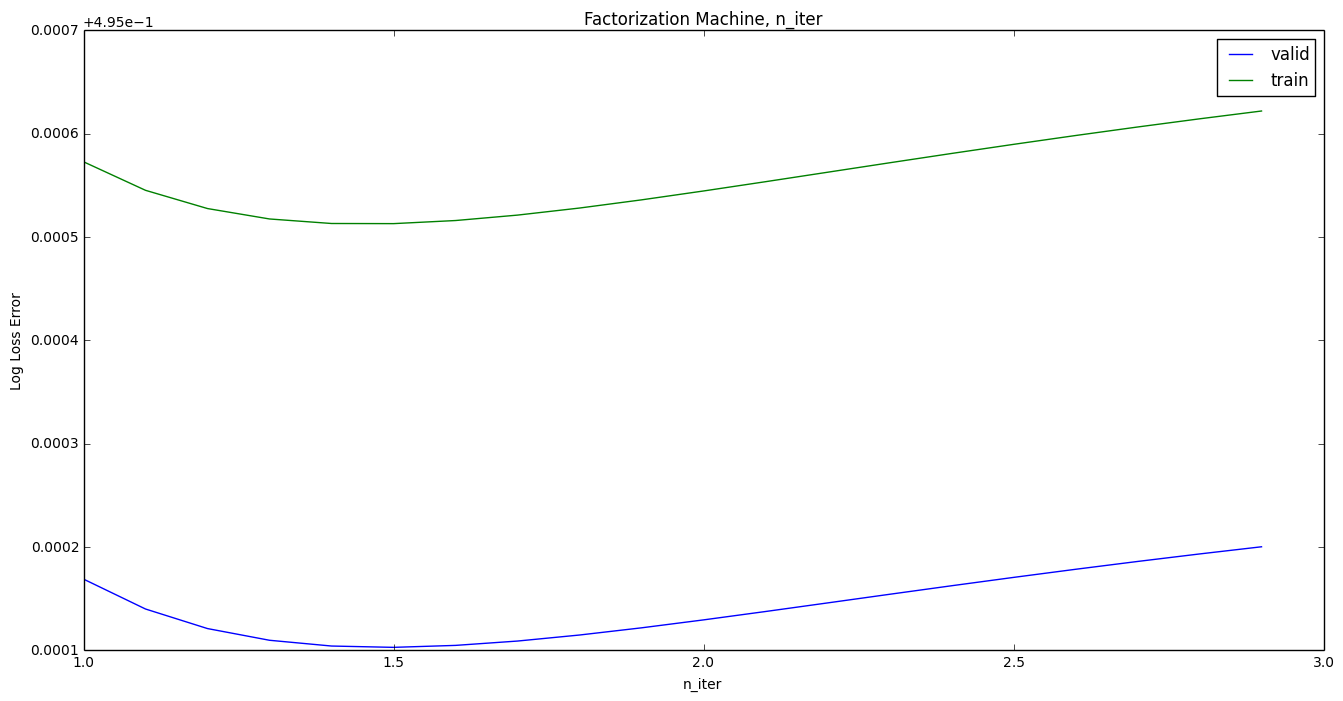

In [64]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1.0, 3.0, 0.1), val_error, label='valid')
plt.plot(np.arange(1.0, 3.0, 0.1), train_error, label='train')
plt.title('Factorization Machine, n_iter')

plt.xlabel('n_iter')
plt.ylabel('Log Loss Error')
plt.legend()

In [23]:
%%time

# Prepare 5 fold stacking.
fm_mcmc = mcmc.FMClassification(n_iter=30, init_stdev=0.2, rank=2)
five_fold_train(x_train, y_labels, fm_mcmc, name='fm_mcmc', folds=5)

('Folds: ', 1)
('Train Loss: ', 0.11536490282421956)
('Val Loss: ', 0.20289536403463473)
('Folds: ', 2)
('Train Loss: ', 0.1125788826447426)
('Val Loss: ', 0.21313945885797694)
('Folds: ', 3)
('Train Loss: ', 0.11449794283277044)
('Val Loss: ', 0.20360985369529194)
('Folds: ', 4)
('Train Loss: ', 0.10740217626503845)
('Val Loss: ', 0.21050962888672908)
('Folds: ', 5)
('Train Loss: ', 0.11169695707373443)
('Val Loss: ', 0.20105418825696816)
CPU times: user 52min 16s, sys: 2min 35s, total: 54min 52s
Wall time: 55min 42s


In [13]:
%%time

# Running loops to see which iteration is the best

iter_ = []
val = []
print('Starting...')
for i in range(10, 90, 10):
    fm_mcmc = mcmc.FMClassification(n_iter=i, init_stdev=0.2, rank=2)
    v1 = fm_mcmc.fit_predict_proba( \
                            sparse.vstack((train_fold1, train_fold2), format='csr'), \
                            np.concatenate((y_labels_1, y_labels_2), axis=0), \
                            sparse.vstack((train_fold1, train_fold2), format='csr'))
    loss = log_loss(np.concatenate((y_train_fold1.toarray().flatten(), \
                                    y_train_fold2.toarray().flatten()), axis=0), v1)
    val.append(loss)
    iter_.append(i)
    print('Iteration: ', i, ' Loss: ', loss)

Starting...
('Iteration: ', 10, ' Loss: ', 0.23328224131835382)
('Iteration: ', 20, ' Loss: ', 0.16626218516798097)
('Iteration: ', 30, ' Loss: ', 0.11383954517700155)
('Iteration: ', 40, ' Loss: ', 0.08318201193704719)
('Iteration: ', 50, ' Loss: ', 0.065151234838048175)
('Iteration: ', 60, ' Loss: ', 0.053512648252593553)
('Iteration: ', 70, ' Loss: ', 0.045408121602147113)
('Iteration: ', 80, ' Loss: ', 0.039442937678799507)
CPU times: user 55min 44s, sys: 2min 53s, total: 58min 37s
Wall time: 1h 12min 8s


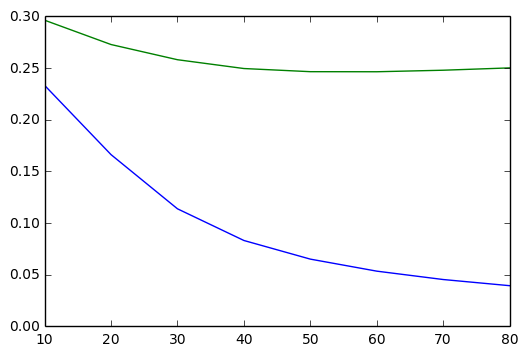

In [32]:
iter_ = range(10, 90, 10)

train_loss = [0.23328224131835382, 0.16626218516798097, \
              0.11383954517700155, 0.08318201193704719, \
              0.065151234838048175, 0.053512648252593553, \
              0.045408121602147113, 0.039442937678799507]

val_loss = [0.29635985281367316, 0.27281625323744485, \
            0.25811935994265833, 0.24959554223932273, \
            0.24654452770989402, 0.24647524110967836, \
            0.24795721205759236, 0.25021013790583069]
plt.plot(iter_, train_loss)
plt.plot(iter_, val_loss)

In [36]:
%%time


# Prepare for 2 fold stacking
fm_mcmc = mcmc.FMClassification(n_iter=30, init_stdev=0.2, rank=2)

def get_2fold_stack_fm(model):
    new_fold2 = model.fit_predict_proba(train_fold1, y_labels_1, train_fold2)
    v1 = model.fit_predict_proba(train_fold1, y_labels_1, validation_fold)

    new_fold1 = model.fit_predict_proba(train_fold2, y_labels_2, train_fold1)
    v2 = model.fit_predict_proba(train_fold2, y_labels_2, validation_fold)
    
    return np.concatenate([new_fold1, new_fold2], axis=0), (v1+v2)/2

fm_layer_1_train, fm_layer_1_val = get_2fold_stack_fm(fm_mcmc)
log_loss(y_validation_fold.toarray().flatten(), fm_layer_1_val)

In [49]:
# Output 2 fold stacking as feature for layer 2 model.

pd.DataFrame(data={'fm_layer_1_train': fm_layer_1_train}).to_csv('./fm_layer_1_train.csv', index=False)
pd.DataFrame(data={'fm_layer_1_val': fm_layer_1_val}).to_csv('./fm_layer_1_val.csv', index=False)

In [40]:
%%time

# Train on whole whole training set, and predict on test set
fm_mcmc = mcmc.FMClassification(n_iter=30, init_stdev=0.2, rank=2)
fm_layer_1_test = fm_mcmc.fit_predict_proba(\
                                sparse.vstack((train_fold1, train_fold2, validation_fold), format='csr'), \
                                np.concatenate((y_labels_1, y_labels_2, y_labels_val), axis=0), \
                                X_test)
fm_layer_1_test

CPU times: user 14min 48s, sys: 45 s, total: 15min 33s
Wall time: 15min 47s


In [41]:
submission = pd.DataFrame()
submission['test_id'] = pd.read_csv('../kaggle-quora/data/test.csv').index.values
submission['is_duplicate'] = fm_layer_1_test
print submission.head()
submission.to_csv('submission_fm_layer_1_test_iter_30.csv', index=False)

,test_id,is_duplicate
0,0,0.009199
1,1,0.013656
2,2,0.048985
3,3,0.015259
4,4,0.826378


In [150]:
# Train Error, init_stdev = 0.2
# ('Iteration: ', 10, ' Loss: ', 0.23328224131835382)
# ('Iteration: ', 20, ' Loss: ', 0.16626218516798097)
# ('Iteration: ', 30, ' Loss: ', 0.11383954517700155)
# ('Iteration: ', 40, ' Loss: ', 0.08318201193704719)
# ('Iteration: ', 50, ' Loss: ', 0.065151234838048175)
# ('Iteration: ', 60, ' Loss: ', 0.053512648252593553)
# ('Iteration: ', 70, ' Loss: ', 0.045408121602147113)
# ('Iteration: ', 80, ' Loss: ', 0.039442937678799507)

# Val Error, init_stdev = 0.2
# {'Iteration': 10, 'Loss': 0.29635985281367316}
# {'Iteration': 20, 'Loss': 0.27281625323744485}
# {'Iteration': 30, 'Loss': 0.25811935994265833}
# {'Iteration': 40, 'Loss': 0.24959554223932273}
# {'Iteration': 50, 'Loss': 0.24654452770989402}
# {'Iteration': 60, 'Loss': 0.24647524110967836}
# {'Iteration': 70, 'Loss': 0.24795721205759236}
# {'Iteration': 80, 'Loss': 0.25021013790583069}

# Val Error, init_stdev = 0.2
# ('Iteration: ', 45, ' Loss: ', 0.24752426315059886)
# ('Iteration: ', 46, ' Loss: ', 0.24724833842744279)
# ('Iteration: ', 47, ' Loss: ', 0.24702310109441342)
# ('Iteration: ', 48, ' Loss: ', 0.24682389946147332)
# ('Iteration: ', 49, ' Loss: ', 0.24666619224361139)
# ('Iteration: ', 50, ' Loss: ', 0.24654452770989402)
# ('Iteration: ', 51, ' Loss: ', 0.24642553390780714)
# ('Iteration: ', 52, ' Loss: ', 0.24633967743177221)
# ('Iteration: ', 53, ' Loss: ', 0.24627783016829785)
# ('Iteration: ', 54, ' Loss: ', 0.24623407061168606)
# ('Iteration: ', 55, ' Loss: ', 0.24621723186918204)
# ('Iteration: ', 56, ' Loss: ', 0.24623152635006937)
# ('Iteration: ', 57, ' Loss: ', 0.24626810904502541)
# ('Iteration: ', 58, ' Loss: ', 0.24632667073134329)
# ('Iteration: ', 59, ' Loss: ', 0.24639824663684529)
# ('Iteration: ', 60, ' Loss: ', 0.24647524110967836)
# ('Iteration: ', 61, ' Loss: ', 0.2465703410640715)
# ('Iteration: ', 62, ' Loss: ', 0.24668716108316527)
# ('Iteration: ', 63, ' Loss: ', 0.24682921392805598)
# ('Iteration: ', 64, ' Loss: ', 0.24695119751571334)

0.475378806541


# Training XGBoost

In [27]:
print("Training data: X_train: {}, Y_train: {}, X_test: {}".format(x_train.shape, len(y_train), x_test.shape))
clr = train_xgb(x_train, y_train, params)
preds = predict_xgb(clr, x_test)

Training data: X_train: (780486, 50), Y_train: 780486, X_test: (2345796, 50)
Will train XGB for 315 rounds, RandomSeed: 12357
[0]	train-logloss:0.629423	eval-logloss:0.629526
[1]	train-logloss:0.578195	eval-logloss:0.578343
[2]	train-logloss:0.536378	eval-logloss:0.53656
[3]	train-logloss:0.501217	eval-logloss:0.501432
[4]	train-logloss:0.4719	eval-logloss:0.472147
[5]	train-logloss:0.446716	eval-logloss:0.446973
[6]	train-logloss:0.425318	eval-logloss:0.425612
[7]	train-logloss:0.40699	eval-logloss:0.407314
[8]	train-logloss:0.391354	eval-logloss:0.391734
[9]	train-logloss:0.376584	eval-logloss:0.37698
[10]	train-logloss:0.364227	eval-logloss:0.364643
[11]	train-logloss:0.354132	eval-logloss:0.354596
[12]	train-logloss:0.344738	eval-logloss:0.345218
[13]	train-logloss:0.336595	eval-logloss:0.337109
[14]	train-logloss:0.328956	eval-logloss:0.329458
[15]	train-logloss:0.322348	eval-logloss:0.322837
[16]	train-logloss:0.316893	eval-logloss:0.317378
[17]	train-logloss:0.311979	eval-loglos

Writing output...
Features importances...


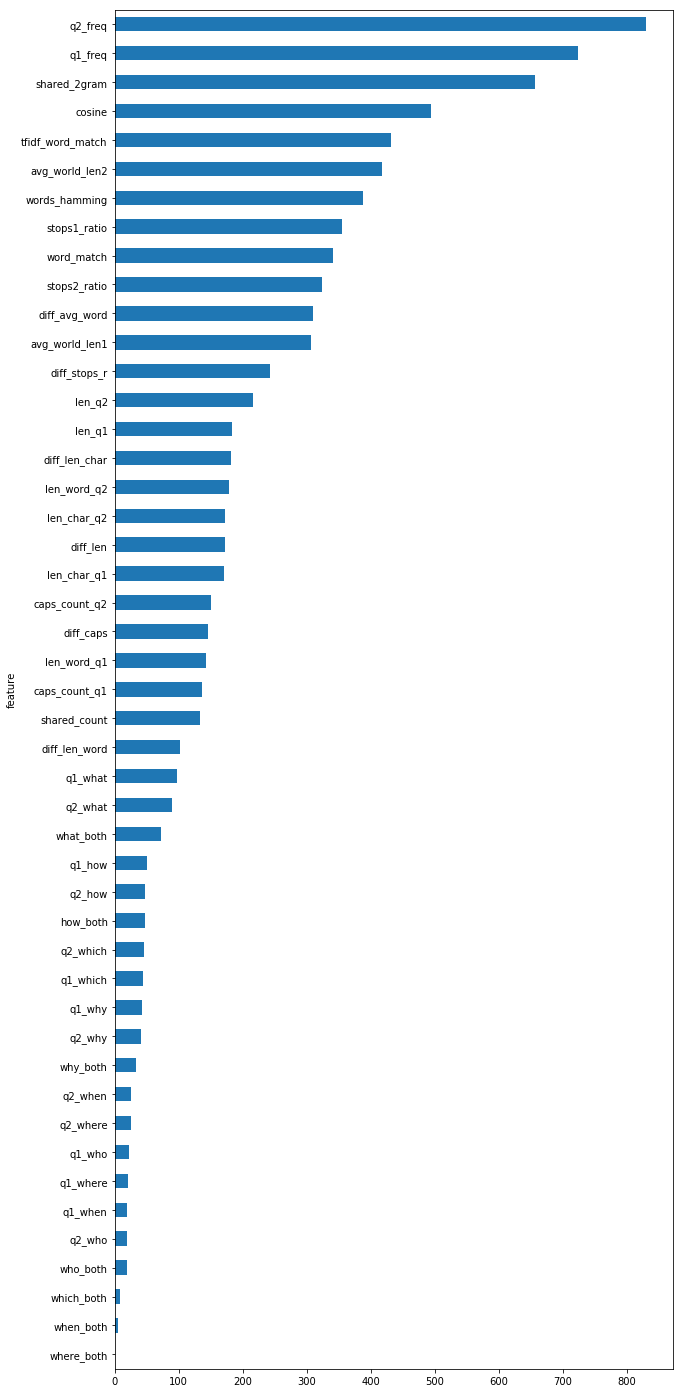

In [30]:
print("Writing output...")
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = preds *.75
sub.to_csv("xgb_seed{}_n{}.csv".format(RS, ROUNDS), index=False)

print("Features importances...")
importance = clr.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.gcf().savefig('features_importance.png')